<a href="https://colab.research.google.com/github/maggiedart16/Earth-and-Environmental-Systems-Modeling/blob/main/mod08_Snow17_calibration_assignment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 08: Model Calibration – Assignment

In this assignment, you will extend the work we have done on model calibration to explore the following questions:

1. When we calibrate the model on RMSE, how sensitive are our optimized parameters to our initial guess? And
2. How different are the results when we calibrate the model on MAE?

To address these questions, you will calibrate the model for four sets of initial guesses that correspond effectively to the four "corners" of our feasible space of parameters `DD` and `Tt`. You will plot the resulting calibrated values of these parameters to investigate the degree to which your calibrated parameters depend on where on the RMSE objective function surface you started. Then you'll repeat the analysis, but instead of calibrating to RMSE, you'll write code to calibrate the Snow-17 model to MAE.

## 1. Notebook Setup

Below we load the libraries we will need and initialize important variables

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import numbers

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

# The name of the file containing parameter combinations and associated KGE values from our
# sensitivity analysis
saved_error_metric_values_fname = 'Snow17_sensitivity_analysis.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

DD_i = np.array([2.0, 2.0, 9.0, 9.0]) # Initial guesses for degree-day factor
Tt_i = np.array([0.0, 6.0, 6.0, 0.0]) # Initial guesses for temperature threshold


## 2. Load the Forcing Data

This data corresponds to the same East River watershed data we have been using throughout this module.

In [25]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values
SWE_o = df_forcing[date_beg:date_end]['SWE'].values

t = pd.date_range(start=date_beg, end=date_end, freq='1D')

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


## 3. Define Some Critical Functions

### 3.1 Create a Function Defining the Snow-17 Model

In [26]:
def Snow17(Ta,P,DD,Tt):

    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)

    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)

    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed,
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.

        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0

        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0

        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i


    return SWE_s17, Sm_s17, Pliq_s17

### 3.2 Create a Function to Calculate RMSE

In [27]:
def RMSE(y_m,y_o):

    # Inputs:
    # y_m: Modeled time series
    # y_o: Observed time series

    RMSE = np.sqrt(np.nanmean((y_m - y_o)**2))

    return RMSE

### 3.3 Create an Objective Function Based on RMSE

In [28]:
def objective_function_rmse(params):
    DD_exp, Tt_exp = params # Get DD and Tt parameters

    # 1. Call Snow-17 model
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)

    # 2. Get RMSE value for simulated SWE
    RMSE_exp = RMSE(SWE_m,SWE_o)

    # 3. Return RMSE because the optimization function we're using seeks minimization
    return RMSE_exp


## 4. Calibrate on RMSE

Below, find the lines with comments labelled `TODO:` and insert/modify the code appropriately

In [29]:
N_ig = DD_i.size # The number of initial conditions being considered

# TODO: Create containers to store optimized DD and Tt
DD_opt = np.zeros((N_ig,))
Tt_opt = np.zeros((N_ig,))


for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]] # TODO: Get the initial conditions for this combination

    # Calibrate the model based on this initial guess
    optimized_params_rmse = optimize.minimize(
        objective_function_rmse,
        initial_guess,
        method='CG',
        jac='3-point',
        options={
            'disp': True,
            'maxiter': 2000,
        }
        )

    # Print the values of the optimized parameters to the screen
    print("Optimized Parameters:", optimized_params_rmse.x)

    # TODO: Store the calibrated parameters in the array you created above
    DD_opt[i] = optimized_params_rmse.x[0]
    Tt_opt[i] = optimized_params_rmse.x[1]



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 60.201041
         Iterations: 0
         Function evaluations: 342
         Gradient evaluations: 66
Optimized Parameters: [2. 0.]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602012
         Iterations: 9
         Function evaluations: 437
         Gradient evaluations: 85
Optimized Parameters: [7.66340649 4.28108359]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602336
         Iterations: 10
         Function evaluations: 610
         Gradient evaluations: 118
Optimized Parameters: [7.6447222  4.27966492]
         Current function value: 32.602189
         Iterations: 13
         Function evaluations: 476
         Gradient evaluations: 93
Optimized Parameters: [7.69057233 4.28314745]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 4.1 Plot the Results

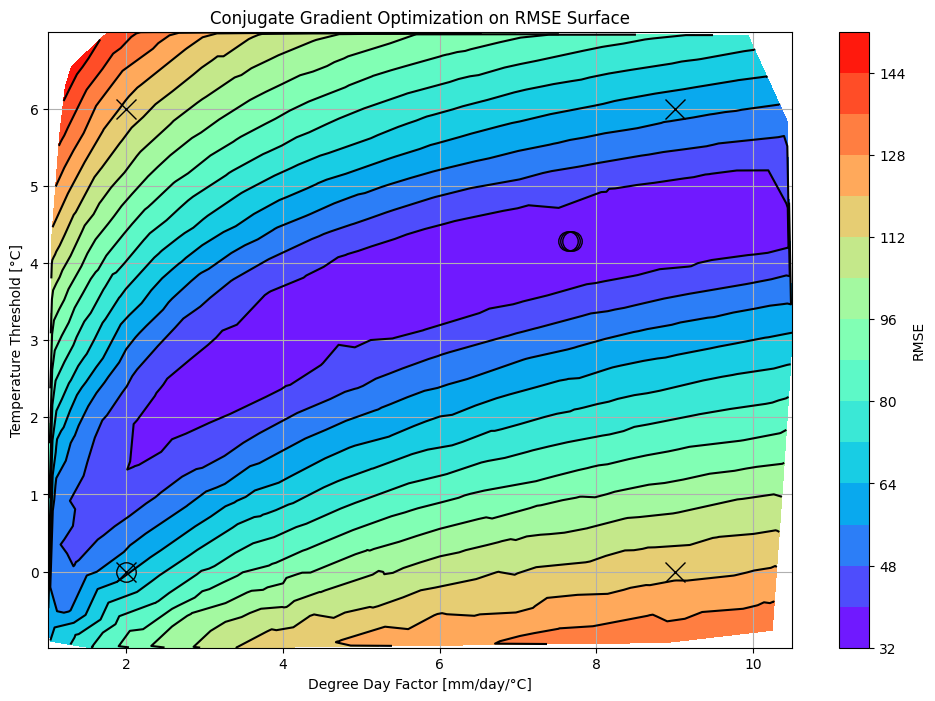

In [30]:
# TODO:
# 1. Read in the RMSE surface we created in the sensitivity analysis/brute force calibration notebook
df_error_metric_sa = pd.read_csv(saved_error_metric_values_fname)

DD_sa = df_error_metric_sa['DD_sa'].values
Tt_sa = df_error_metric_sa['Tt_sa'].values
RMSE_sa = df_error_metric_sa['RMSE_sa'].values

# 2. Use the contour() and contourf() to create a plot of the RMSE surface
# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KGE surface
contour = ax.tricontour(DD_sa,Tt_sa,RMSE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,RMSE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label("RMSE")

# Add labels
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on RMSE Surface')

# 3. Plot the initial guesses on the plot as large Xs (see the markersize property in matplotlib)
plt.plot(DD_i,Tt_i,'kx', markersize=14, label='Initial Guess')

# 4. Plot the optimized guesses on the plot as large Os
plt.plot(DD_opt,Tt_opt,'ko', markersize=14, mfc='none', label='Initial Guess')

## 5. Now Calibrate to MAE

Now you will repeat the above analysis, but instead calibrate the model to the mean absolute error (MAE), an error metric we also examined in our sensitivity analysis.

### 5.1 Define a Function to Calculate MAE

In [31]:
def MAE(y_m,y_o):
    # TODO: Add code here

    MAE = np.nanmean(np.abs(y_m - y_o))

    return MAE

### 5.2 Create an Objective Function Based on MAE

In [32]:
def objective_function_mae(params):
    # TODO: Get the parameters
    DD_exp, Tt_exp = params

    # TODO: Calculate SWE with input parameters
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)

    # TODO: Call function to calculate MAE
    MAE_exp = MAE(SWE_m,SWE_o)

    return MAE_exp

### 5.3 Calibrate the Model to MAE

Use the code immediately below section 4 above to calibrate the model. Use the same 4 initial guesses we defined at the top of the notebook.

In [33]:
# TODO: Insert code to call `optimize.minimize()` for each initial guess and using MAE
DD_opt_mae = np.zeros((N_ig,))
Tt_opt_mae = np.zeros((N_ig,))

for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]] # Get the initial conditions for this combination

    # Calibrate the model based on this initial guess
    optimized_params_mae = optimize.minimize(
        objective_function_mae,
        initial_guess,
        method='CG',
        jac='3-point',
        options={
            'disp': True,
            'maxiter': 2000,
        }
        )

    # Print the values of the optimized parameters to the screen
    print("Optimized Parameters:", optimized_params_mae.x)

    # TODO: Store the calibrated parameters in the array you created above
    DD_opt_mae[i] = optimized_params_mae.x[0]
    Tt_opt_mae[i] = optimized_params_mae.x[1]

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 30.488001
         Iterations: 0
         Function evaluations: 437
         Gradient evaluations: 85
Optimized Parameters: [2. 0.]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 15.701677
         Iterations: 15
         Function evaluations: 674
         Gradient evaluations: 133
Optimized Parameters: [7.73332819 4.28620179]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 16.198452
         Iterations: 2
         Function evaluations: 316
         Gradient evaluations: 63
Optimized Parameters: [9.24188977 4.46749179]
         Current function value: 15.702013
         Iterations: 8
         Function evaluations: 360
         Gradient evaluations: 71
Optimized Parameters: [7.69828936 4.28312272]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 5.4 Plot the Results

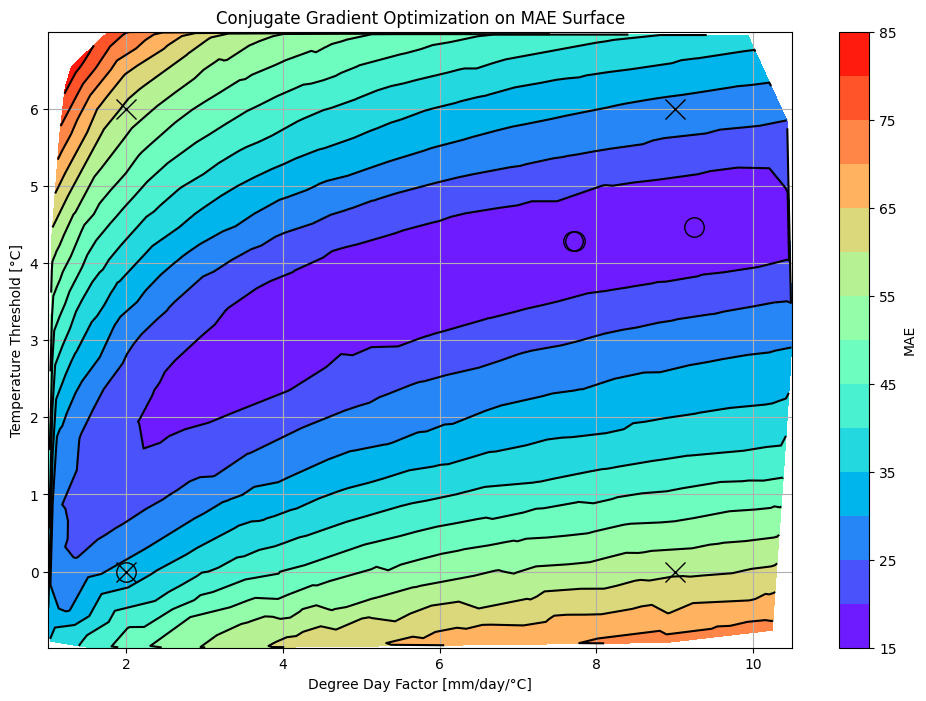

In [34]:
# TODO:
# 1. Read in the MAE surface we created in the sensitivity analysis/brute force calibration notebook
DD_sa = df_error_metric_sa['DD_sa'].values
Tt_sa = df_error_metric_sa['Tt_sa'].values
MAE_sa = df_error_metric_sa['MAE_sa'].values

# 2. Use the contour() and contourf() to create a plot of the MAE surface
fig, ax = plt.subplots(figsize=(12, 8))

contour = ax.tricontour(DD_sa,Tt_sa,MAE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,MAE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label("MAE")

# Add labels

plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on MAE Surface')

# 3. Plot the initial guesses on the plot as large Xs
plt.plot(DD_i,Tt_i,'kx', markersize=14, label='Initial Guess')

# 4. Plot the optimized guesses on the plot as large Os
plt.plot(DD_opt_mae,Tt_opt_mae,'ko', markersize=14, mfc='none', label='Initial Guess')


## 6 Reflection Questions

Answer the following reflection questions:

1. How sensitive are the optimized parameters to the initial guess? Did calibrating to MAE result in appreciably different results when compared to calibrating to RMSE?  
*The optimized parameters are somewhat sensitive to the initial guesses. I noticed that for different initial guesses, the optimized values of DD and Tt could vary significantly, especially when calibrating with RMSE. The optimization process seems to converge to different values depending on where the initial guess is placed on the objective function surface. This suggests that the RMSE surface might have multiple local minima, and the optimizer might get stuck in one of them, especially when the starting values are far from the true optimal ones. However, in some cases, the parameters converged to similar values, which might indicate that the objective function is relatively smooth or that the initial guess was close to the optimal solution.*
*When calibrating with MAE, the results were generally similar, though the values for DD and Tt differ slightly from those obtained using RMSE, particularly in cases where there were outliers in the observed data. MAE treats all errors equally, which could lead to more balanced results across the entire time series.*

2. What are the implications of the above results? How would you coach a colleague who is considering creating a Snow-17 model for a different location in, for example, Washington or Idaho?
*For someone building a similar model in another location, like Washington or Idaho, I would recommend starting with multiple initial guesses for the parameters to test if the model is sensitive to the starting point. It's clear from this assignment that optimization can be sensitive to where you start, especially if the objective function has local minima. A thorough sensitivity analysis, like the one we did here, can help identify a good range of initial guesses.*

*I would also advise my colleague to carefully choose the error metric depending on the local conditions and the data they have. If they expect large outliers in the data (for example, unusually heavy snowstorms), RMSE might be better because it will penalize these large deviations more strongly. However, if the data is relatively clean and they want a more balanced error metric, MAE could be a better option because it treats all errors equally.*

3. How generalizable do you think your conclusions are for __*other*__ models? Based on what we've done in this module? How might you approach calibration of a model that is of a completely different process but of similar complexity? For example, say you needed to calibrate the advection-dispersion code to a time series of contaminant concentration in an observation well some known distance away from an oil spill with a known date?  
*I think the conclusions from this exercise are fairly generalizable to other models, especially those involving complex processes like snowmelt or hydrological forecasting. The key principles, such as sensitivity to initial guesses, the importance of error metrics, and the potential for multiple local minima in optimization, apply to many different types of models. For example, if I were calibrating a model for contaminant transport in groundwater or even a model for air quality prediction, I would expect similar challenges.*

*However, every model is different, so I'd expect there to be some unique challenges depending on the model type and the data available. For instance, a model like Snow-17, which involves processes like snow accumulation and melting, has its own specific dynamics. Other models, such as advection-dispersion models for contaminant transport, would require different considerations, such as including boundary conditions or reaction rates in the calibration process.*

*In general, I think the lessons learned in this module would guide me in calibrating any complex environmental model, but I would always make sure to adapt the calibration process to the specifics of the model and the data I’m working with.*

